In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json

# sub function and class

In [27]:
def cut_fish_img(img, background, mean, std, mask, size):
    a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    a = cv2.absdiff(a, background)
    outer = a*mask
    outer = np.where(outer>(mean+std*10), 255, 0).astype('uint8')
    M = cv2.moments(outer)

    pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 

    return pos, cutting_img(img, pos, size)

def partial_img(img, size = 150):
    #find the center and cut the image
    M = cv2.moments(img)

    cX = int(M["m01"] / M["m00"])
    cY = int(M["m10"] / M["m00"])

    startX = cX - size
    endX = cX + size

    if startX<0:
        startX=0
    if endX>=img.shape[0]:
        endX=img.shape[0]-1

    startY = cY - size
    endY = cY + size
    if startY<0:
        startY=0
    if endY>=img.shape[1]:
        endY=img.shape[1]-1

    a = img.copy()[startX:endX,startY:endY]
    
    return a, (cX, cY)

def cutting_img(img, pos, size=150):
    cX, cY = pos
    Len = size*2+1
    
    pad_arr=[[0,Len],[0,Len]]
    
    if img.ndim == 2: #1channel
        ndim = 1
        temp = np.zeros((Len, Len), dtype=np.uint8)
    elif img.shape[2] == 1:
        ndim = 1
        temp = np.zeros((Len, Len, 1), dtype=np.uint8)
    elif img.shape[2] == 3:
        ndim = 3
        temp = np.zeros((Len, Len, 3), dtype=np.uint8)
    else:
        raise Exception("wrong channel number!", img.shape)
    
    startX = cX - size
    endX = cX + size + 1
    
    if startX<0:
        pad_arr[0][0] = 0-startX
        startX=0
    if endX>img.shape[0]:
        pad_arr[0][1] = -endX+img.shape[0]
        endX=img.shape[0]
        
        
    startY = cY - size
    endY = cY + size + 1

    if startY<0:
        pad_arr[1][0] = 0-startY
        startY=0
    if endY>img.shape[1]:
        pad_arr[1][1] = -endY+img.shape[1]
        endY=img.shape[1]
    
    temp[pad_arr[0][0]:pad_arr[0][1], pad_arr[1][0]:pad_arr[1][1], ...]= img[startX:endX, startY:endY, ...]
    return temp

def mean_generater(imgs, background, mask):
    
    outer = []
    for img in imgs:
        a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        a = cv2.absdiff(a, background)
        outer.append(a*mask)
    outer = np.array(outer)
    
    return np.mean(outer), np.std(outer)

"""class compress_tiff:
    
    def __init__(self, path, savepath=None, name=None):

                    
        if name is None:
            self.name = "exp_compress"
        else:
            self.name = name
            
        if savepath is None:
            self.savepath = os.path.join(path, self.name)
        else:
            self.savepath = os.path.join(savepath, self.name)
        self.path = path
        
        flist = os.listdir(path)
        tiflist = []
        for filename in flist:
            if os.path.isdir(filename):
                continue
            if filename.split(".")[-1] == "tiff":
                tiflist.append(filename)

        #rint('There is a total of ',len(tiflist), 'images')
        #for srt in os.listdir(path):
        #flist.append(srt.split('_'))

        tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]) )
        
        flist = []
        for filename in tiflist:
            flist.append(os.path.join(path, filename))
        
        self.flist = flist.copy()
        
        return 
    def compress(self):
            os.mkdir(self.savepath)
            self.back = BG_tiff(self.flist, 500)
            tiff.imwrite(os.path.join(self.savepath, "background.tiff", self.back.cbackground))
            
            background = self.back.background
            
            
    def gen_config(self):
        f = open(os.path.join(self.path, self.name+".conf", "w"))"""

class BG_tiff:
    def __init__(self, imgslist, nbckgnd = 1000):
        img_shape = tiff.imread(imgslist[0]).shape[0:2]
        total = np.zeros(img_shape)
        ctotal = np.zeros((*img_shape,3))
        for file in imgslist[0:nbckgnd]:
            b = tiff.TiffFile(file).asarray()
            ctotal += b
            b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            total = total + b 
        self.cbackground = (ctotal/nbckgnd).astype('uint8')
        self.background = (total/nbckgnd).astype('uint8')
        self.shape = img_shape
        
        back_itr = np.zeros(self.shape, dtype='uint8')
        back_itr = cv2.normalize(self.background.copy(), back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)   
   
        R=self.shape[0]
        pos = [0]*4
        R_L = [0]*4
        cir_num = 0
        while True:
            try:
                pos[cir_num], R_L[cir_num] = self.findcir(back_itr, R-20)
            except:
                break
            R = R_L[cir_num]

            mask = np.zeros(back_itr.shape, dtype = 'uint8')
            mask = cv2.circle(mask, pos[cir_num], R_L[cir_num], 255, -1)>100

            back_itr = back_itr*mask
            back_itr = cv2.normalize(back_itr, back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)
            cir_num+=1
            
        self.cir_num = cir_num
        self.R_L = R_L
        self.pos = pos
        
    def findcir(self, img, maxR):
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 100, maxRadius = maxR)
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x,y,r) in circles[:1]:
            pos = (x, y)
            MaxR = r

        return pos, MaxR
    
    def gen_mask(self,Rn, ch=1):
        
        if Rn >= self.cir_num:
            raise Exception("GG, too big")
            return
        
        if ch == 3:
            shape = (*(self.shape),3)
            black = (0,0,0)
            white = (255,255,255)
        elif ch == 1:
            shape = self.shape
            black = (0)
            white = 255
            
        if Rn == 0:
            mask = np.full(shape, 255, dtype = 'uint8')
            mask = cv2.circle(mask, self.pos[0], self.R_L[0], black, -1)
            mask = mask>100
        
        else:
            mask = np.zeros(shape, dtype = 'uint8')
            cv2.circle(mask, self.pos[Rn-1], self.R_L[Rn-1], white, -1)
            cv2.circle(mask, self.pos[Rn], self.R_L[Rn], black, -1)
            mask = mask>100
            
        return mask

# load image path and sort

In [39]:
#指定路徑(絕對路徑)
path = "/home/isis0517/Documents/data/compress/HMMTest_01/"
savepath = "/home/isis0517/Documents/data/compress/HMMTest_01_com"

if not os.path.isdir(savepath):
    os.mkdir(savepath)

flist = os.listdir(path)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "tiff":
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(path, filename))

There is a total of  54016 images


# generate background

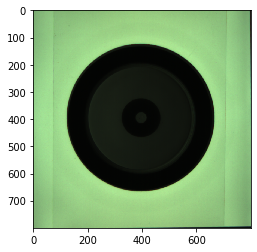

In [40]:
back = BG_tiff(flist)
plt.imshow(back.cbackground)
plt.show()
tiff.imwrite(os.path.join(savepath, "background.tiff"), back.cbackground)
background = back.background

# generate mask

In [41]:
inner_mask = back.gen_mask(2)
outer_mask = back.gen_mask(0)

# cutting the image and save

In [42]:
# size 決定要切成多大
size = 100
# 每次迴圈處理幾個image(一次讀入的數量，注意記憶體大小)
group_len = 1000

In [48]:
pos1 = []
pos2 = []
video1 = cv2.VideoWriter(os.path.join(savepath, "video1.avi"), int(1196444237), 30, (size*2+1,size*2+1))
video2 = cv2.VideoWriter(os.path.join(savepath, "video2.avi"), int(1196444237), 30, (size*2+1,size*2+1))

imgs = tiff.TiffSequence(flist[0:500]).asarray()
outer_mean, outer_std = mean_generater(imgs, background, outer_mask)
inner_mean, inner_std = mean_generater(imgs, background, inner_mask)

start = time.time()

for s in range(len(flist)//group_len):
    
    imgs = tiff.TiffSequence(flist[s*group_len:(s+1)*group_len]).asarray()
    
    read_time = time.time()
    
    for img in imgs:
        pos, cimg = cut_fish_img(img, background, outer_mean, outer_std, outer_mask, size)
        pos1.append(pos)
        video1.write(cimg)
        
        pos, cimg = cut_fish_img(img, background, inner_mean, inner_std, inner_mask, size)
        pos2.append(pos)
        video2.write(cimg)
    print((s+1)*group_len, "read time", read_time-start, "write time", time.time()-read_time)
    start = time.time()
        
for filename in flist[(len(flist)//group_len)*group_len:]:
    img = tiff.TiffFile(filename).asarray()
    pos, cimg = cut_fish_img(img, background, outer_mean, outer_std, outer_mask, size)
    pos1.append(pos)
    video1.write(cimg)
    
    pos, cimg = cut_fish_img(img, background, inner_mean, inner_std, inner_mask, size)
    pos2.append(pos)
    video2.write(cimg)
"""
for filename in tiflist:
    a = tiff.TiffFile(path+filename).asarray()
    Cimg = a.copy()
    a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    a = cv2.absdiff(a, background)
    in_fish = a*outer_mask
    in_fish = np.where(in_fish>(mean+std*15), 255, 0).astype('uint8')
    _, pos = partial_img(in_fish)
    pos1.append(pos)
    video1.write(cutting_img(Cimg, pos, size))
"""
video1.release()
video2.release()

np.save(os.path.join(savepath, "pos1.npy"), pos1)
np.save(os.path.join(savepath, "pos2.npy"), pos2)

config = {"size": size, "frame_num":frame_num, "version" : "alpha",
          "date": time.strftime("%Y-%m-%d %H:%M", time.localtime()), "shape":background.shape}

with open(os.path.join(savepath, "save.config"), 'w', newline='') as jsonfile:
    json.dump(config, jsonfile, indent=4)



1000 read time 3.3800947666168213 write time 8.159854173660278
2000 read time 5.320504665374756 write time 10.148075580596924
3000 read time 5.340665340423584 write time 10.172017812728882
4000 read time 5.097292184829712 write time 9.933561086654663
5000 read time 5.27408242225647 write time 10.16461992263794
6000 read time 5.230103969573975 write time 10.09445595741272
7000 read time 5.1753692626953125 write time 10.007218360900879
8000 read time 5.413977861404419 write time 10.275567054748535
9000 read time 5.365255355834961 write time 10.24837350845337
10000 read time 5.4175803661346436 write time 10.316997051239014
11000 read time 5.132812023162842 write time 9.993546724319458
12000 read time 5.319046258926392 write time 10.170705080032349
13000 read time 5.3919501304626465 write time 10.199861526489258
14000 read time 5.193687677383423 write time 9.951867818832397
15000 read time 5.431415796279907 write time 10.214838027954102
16000 read time 5.451112985610962 write time 10.23103